In [408]:
# %run code/add_data.py
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
from pandasql import sqldf
import json
import requests
import os
import seaborn as sns

os.system("ls data/zippedData | grep sv > file_list.txt")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline



In [409]:
with open ('file_list.txt', 'r') as f:
    file_list= f.readlines()
    
csv_dict = {}

for csv in file_list:
    file='data/ZippedData/'+csv.strip()
    df_name=csv.strip()
    if 'csv' in file:
        df_name=df_name.split('.csv.gz')[0]
        df=pd.read_csv(file, compression='gzip')
    elif 'tsv' in file:
        df_name=df_name.split('.tsv.gz')[0]
        df=pd.read_csv(file, compression='gzip', delimiter='\t', encoding='latin-1')
    else: print(file, ": unkown file!")
    csv_dict[df_name] = df
    

csv_dict.get('tmdb_imdb_gross_full').drop(columns=["Unnamed: 0"], inplace=True)
#csv_dict["tmdb_imdb_gross_full"].drop(df.index[1], inplace=True)


In [410]:
def gross_to_num(gross_str):
    try:
        gross_num=float(gross_str.replace('$','').replace(',',''))
        
    except:
        return np.NaN
    else:
        return gross_num
    
def extract_year(year_string):
    if ',' in year_string:
        return year_string.split(',')[1].strip()
    else:
        return(year_string)
    
def clean_genres(genre_str):
    filter_list=[]
    try:
        filter_str=genre_str.replace('''[''','').replace(''']''','')
    except:
        None
    else:
        if filter_str == '': 
            filter_list=np.NaN
        else:
            filter_str=genre_str.replace('[','').replace(']','')
            filter_list=filter_str.split(',')
    return filter_list

In [411]:
print(csv_dict.keys())

dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tmdb_genres', 'tmdb_imdb_gross', 'tmdb_imdb_gross_full', 'tmdb_movie_ids', 'tn.movie_budgets'])


In [412]:
csv_dict["tmdb_imdb_gross_full"]["year"]=csv_dict["tmdb_imdb_gross_full"]["release_date"].map(lambda x: str(x)[0:4])
tmdb_imdb_gross_full=csv_dict["tmdb_imdb_gross_full"]
tmdb_imdb_gross=csv_dict["tmdb_imdb_gross"]

sql="""select cast(id as integer) id, tconst, title, release_date,
    cast(revenue as integer) revenue , cast(budget as integer) budget , 
    cast(vote_average as integer) vote_average, cast(popularity as integer) popularity, 
    cast(vote_count as integer) vote_count, cast(runtime as integer) runtime, 
    genres, year
    from tmdb_imdb_gross_full
    where  popularity!='popularity';"""

tmdb_budget=sqldf(sql,globals())

tmdb_budget.head()

,id,tconst,title,release_date,revenue,budget,vote_average,popularity,vote_count,runtime,genres,year
0,6124,tt0011436,"Peter Voss, Thief of Millions",1921-01-01,0,0,0,0,0,420.0,[12],1921
1,25449,None,New World Disorder 9: Never Enough,2008-12-08,0,0,6,1,3,69.0,[],2008
2,2,tt0094675,Ariel,1988-10-21,0,0,6,9,155,73.0,"[18, 80, 35]",1988
3,5,tt0113101,Four Rooms,1995-12-09,4257354,4000000,5,15,2123,98.0,"[80, 35]",1995
4,8,tt0825671,Life in Loops (A Megacities RMX),2006-01-01,0,42000,7,1,18,80.0,[99],2006


In [413]:
# prepairing gross columns in tn.movie_budgets, tmbdb_imdb_gross, and bom.movie_gross
csv_dict["tn.movie_budgets"]["tn_worldwide_gross"]=csv_dict["tn.movie_budgets"]["worldwide_gross"].apply(gross_to_num)
csv_dict["tn.movie_budgets"]["tn_production_budget"]=csv_dict["tn.movie_budgets"]["production_budget"].apply(gross_to_num)
csv_dict["tn.movie_budgets"]["tn_net_profit"]=csv_dict["tn.movie_budgets"]["tn_worldwide_gross"]-csv_dict["tn.movie_budgets"]["tn_production_budget"]


csv_dict["bom.movie_gross"]["foreign_gross_fixed"]=csv_dict["bom.movie_gross"].loc[:,"foreign_gross"].apply(gross_to_num)
csv_dict["bom.movie_gross"]["foreign_gross_fixed"].replace(np.NaN,0, inplace=True)
csv_dict["bom.movie_gross"]["domestic_gross"].replace(np.NaN,0, inplace=True)
csv_dict["bom.movie_gross"]["bom_total_gross"]=csv_dict["bom.movie_gross"]["domestic_gross"] + csv_dict["bom.movie_gross"]["foreign_gross_fixed"]
#csv_dict["bom.movie_gross"].info()

csv_dict["tn.movie_budgets"].head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tn_worldwide_gross,tn_production_budget,tn_net_profit
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279","2,776,345,279.0","425,000,000.0","2,351,345,279.0"


In [414]:
csv_dict.get("tn.movie_budgets")["release_date"]=csv_dict.get("tn.movie_budgets")["release_date"].apply(extract_year)
csv_dict["bom.movie_gross"]["year"]=csv_dict["bom.movie_gross"]["year"].map(lambda x: str(x))  



In [415]:

temp1_df=tmdb_budget.merge(csv_dict.get("tn.movie_budgets")[["movie", "tn_production_budget", "tn_net_profit", "tn_worldwide_gross", "release_date" ]], \
                           left_on=['title','year'], right_on=["movie","release_date"], how="left")

full_merge_df=temp1_df.merge(csv_dict.get("bom.movie_gross")[["title","bom_total_gross","year"]], \
                            left_on=['title','year'], right_on=["title","year"], how="left")

                 

In [416]:
full_merge_df["tn_worldwide_gross"].replace(0,np.NaN, inplace=True)
full_merge_df["bom_total_gross"].replace(0,np.NaN, inplace=True)
full_merge_df["tn_production_budget"].replace(0,np.NaN, inplace=True)
full_merge_df["tn_net_profit"].replace(0,np.NaN, inplace=True)
#full_merge_df["tmdb_net_profit"].replace(0,np.NaN, inplace=True)
full_merge_df["budget"].replace(0,np.NaN, inplace=True)
full_merge_df["revenue"].replace(0,np.NaN, inplace=True)


In [417]:
#full_merge_df["budget"].notna().sum()
full_merge_df["revenue"].notna().sum()

7600

In [418]:
None


In [419]:

full_merge_df["budget"].fillna(full_merge_df["tn_production_budget"], inplace=True)
full_merge_df["revenue"].fillna(full_merge_df["tn_worldwide_gross"], inplace=True)
full_merge_df["revenue"].fillna(full_merge_df["bom_total_gross"], inplace=True)
full_merge_df["year"].fillna(full_merge_df["release_date_y"], inplace=True)


full_merge_df.dropna(subset=["revenue"], inplace=True)

full_merge_df["tmdb_net_profit"]  = full_merge_df["revenue"]-full_merge_df["budget"]



#columns=["original_title","start_year","gross", "release_date","movie", "worldwide_gross_num"]
#merged2_df.drop(columns=columns, inplace=True)

In [420]:
sql="""
select id, tconst, title,  release_date_x release_date, revenue, budget,  tmdb_net_profit net_profit, year, 
vote_average, popularity, vote_count, runtime, genres
from full_merge_df
"""

full_profit_df=sqldf(sql, globals())

len(full_profit_df)



8235

In [421]:
full_profit_df['genre_id']=full_profit_df['genres'].apply(clean_genres)
full_profit_df.drop(columns='genres', inplace=True)

                                                  

In [422]:
profit_by_genre_df=full_profit_df.explode('genre_id')[[ "tconst", "title", "year", "revenue", "budget", "net_profit", "genre_id" ]]


csv_dict["tmdb_genres"]["id"]=csv_dict["tmdb_genres"]["id"].astype(str)
profit_by_genre_df=profit_by_genre_df.merge(csv_dict["tmdb_genres"], left_on=["genre_id"], right_on=["id"], how="inner")

profit_by_genre_df.rename(columns={"name":"genre"}, inplace=True)
profit_by_genre_df.drop(columns=["Unnamed: 0","id"])

,tconst,title,year,revenue,budget,net_profit,genre_id,genre
0,tt0113101,Four Rooms,1995,"4,257,354.0","4,000,000.0","257,354.0",80,Crime
1,tt0052561,Anatomy of a Murder,1959,"8,000,000.0","2,000,000.0","6,000,000.0",80,Crime
2,tt0110413,Léon: The Professional,1994,"45,284,974.0","16,000,000.0","29,284,974.0",80,Crime
3,tt0075314,Taxi Driver,1976,"28,570,902.0","1,300,000.0","27,270,902.0",80,Crime
4,tt0208092,Snatch,2000,"83,557,872.0","10,000,000.0","73,557,872.0",80,Crime
...,...,...,...,...,...,...,...,...
7886,tt0173675,Битва за Москву:Die Aggbession,1985,"6,000,000.0","6,000,000.0",0.0,10752,War
7887,tt0346621,Birthday Girl,2002,"8,130,727.0","13,000,000.0","-4,869,273.0",10770,TV Movie
7888,None,Bellator 175: Rampage vs. King Mo 2,2017,"1,033,113.0",1.0,"1,033,112.0",10770,TV Movie
7889,None,Islanders in the Creek 2: Lundy's Remorse,2021,6.0,1.0,5.0,10770,TV Movie


In [423]:

summary_df=profit_by_genre_df.groupby(['genre'], as_index=False).mean().sort_values(by="net_profit", ascending=False)[['genre','net_profit']]


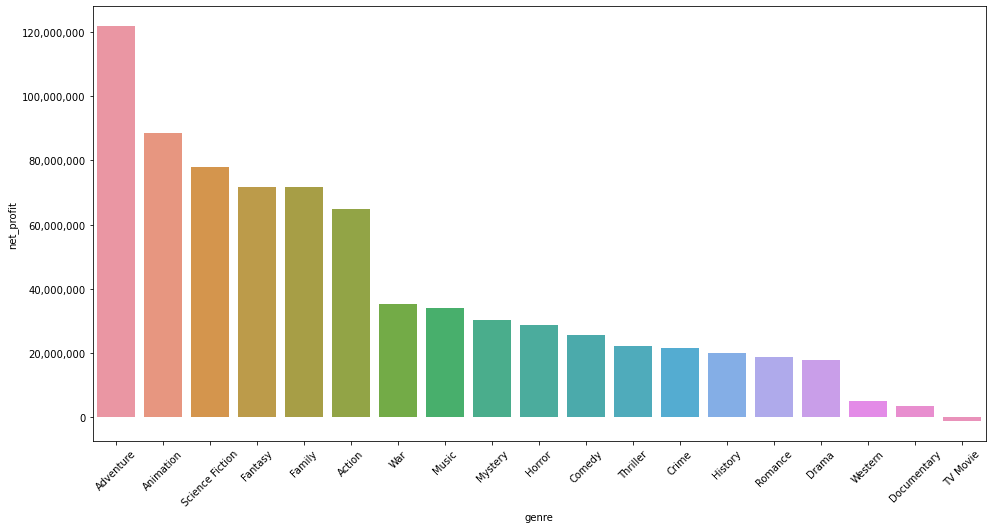

In [424]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)

num_of_ticks=list(range(len(summary_df['genre'])))

fig,ax=plt.subplots(  figsize=(16,8))

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='genre', y='net_profit', data=summary_df, ax=ax);
ax.set_xticks(num_of_ticks);
ax.set_xticklabels(list(summary_df['genre']),  rotation=45);

In [465]:
by_year_df=profit_by_genre_df.groupby(['year'], as_index=False).mean().sort_values(by="year")[['year','net_profit']]

by_year_df.drop(by_year_df.index[108], inplace=True)
by_year_df["year"]=by_year_df["year"].astype(int)


by_year_df=by_year_df[(by_year_df.year > 2005) & (by_year_df.year < 2020)]



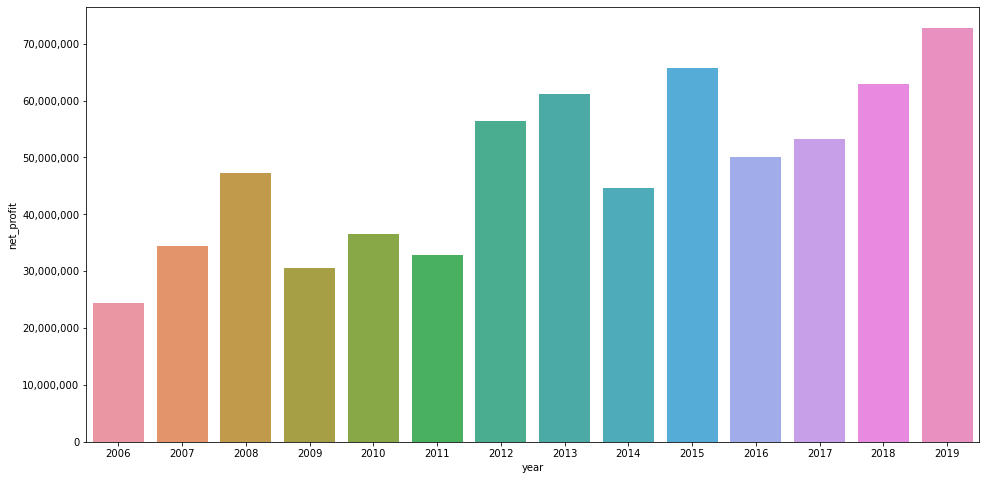

In [466]:


fig,ax=plt.subplots(  figsize=(16,8))

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='year', y='net_profit', data=by_year_df, ax=ax);